In [32]:
%load_ext autoreload
%autoreload 2

# Example Notebook

This notebook is to demonstrate the functionality of the tooling we build to make our ML work more straightforward and interoperable. 

## Data Ingestion Module

At time of writing, we are working exclusively with data stored in the Azure Machine learning Studio Dataset Store. 
The Data Ingestion Module is built ssuch that, if this should change, we should only need to modify ourpipelines very minimally. 

First of all, we can see the datasets available through the AML Studio. 


In [33]:
from data_ingestion import data_ingestion

data_ingestion.list_all_dataset_names_in_registry()

comments_dec
Comment
active-comments
complaints_generated_shuffle
complaints_generated_embeddings
complaints_generated_paraphrased
df_complaints_to_augment_no_numpy
published_eighty_k_1
names_validation_dataset
corrected_false_positives
safeguarding_for_training_v2
Complaints Validate DG
Complaints Train DG
safeguarding_for_validation_v1
safeguarding_for_training_v1
safeguardin_strong
safeguarding_to_replace
safeguarding_training_with_Lee
safeguarding_training_without_Lee
safeguarding_master_raw_data
safeguarding_holdout_1
safeguarding_new_training_data_inc_generated
safeguarding_for_validation_v0
safeguarding_for_training_v0
safeguarding_generated_NLPAUG
Safeguarding_holdout_0
generated_safeguarding_dg
generated_complaints_NLPAUG
published_reviews
complaints_complete_cleansed_v1
complaints_data_augmented
complaints_data_original
train_complaints
train_complaint
complaints_data
description_cleaned
labelled_data_spacy_full_capital
labelled_data_spacy_full
labelled_data_bert_full
review_

Now we can pick one of these and load it in. 
Notice that we select the `retriever_type` as 'AMLStore'. If, in the future, we need to change to SQLStore or Dynamics, our pipelines will be robust against such changes by simply changing this string value. 

In [34]:
dataset_name = "comments_dec"
df_fetched = data_ingestion.DatasetGetter(
    retriever_type="AMLStore", dataset_name=dataset_name
)
df_fetched = df_fetched.dataset
df_fetched.head()

,Comment ID,Organisation ID,Comment Title,Comment Text,Complaint,Rejection Reason,Status,Org Type (Org Name) (Organisation),Org Name,Date of Visit,...,Column40,Column41,Column42,Column43,Column44,Column45,Column46,Column47,Column48,Column49
0,1300019,V013351,Be Honest When you have an accident in a perso...,As a person who has repeatedly been lied about...,No,Dentist complaints,Rejected,Dentist,Ringway Dental Centre,01/05/2022,...,NaT,None,None,None,None,None,None,None,None,None
1,1300264,G85015,Unable to process prescriptions,The practice has repeatedly failed to properly...,No,GP Complaints,Rejected,GP,The Queens Road Partnership,01/05/2022,...,NaT,None,None,None,None,None,None,None,None,None
2,1300306,RKEQ4,Rude and unprofessional reception at the emerg...,"""I came in with my mum who does not speak Engl...",I kindly asked if I can stay with her because...,my mum start crying and I told them that I am...,I walked my mum to waiting area and the triag...,then the reception nurse came and start shout...,None,None,...,NaT,None,None,None,None,None,None,None,None,None
3,"""",No,Hospital and Trust Complaints,Rejected,Hospital,The Whittington Hospital,01/05/2022,Accident and emergency services,NHS website,1,...,NaT,None,None,None,None,None,None,None,None,None
4,1300402,R0A02,Uncaring,Admitted by ambulance to A& E due to Covid 19 ...,No,Hospital and Trust Complaints,Rejected,Hospital,Manchester Royal Infirmary,01/05/2022,...,NaT,None,None,None,None,None,None,None,None,None


# Model Getting Module
See more info in the Readme

## Example Local Model

**Fill this in**

## Example Endpoint Model

In [35]:
from model_getting import model_getting

In [36]:
model_complaints4_janaks = model_getting.ModelGetter(
    retriever_type="Endpoints", model_name="complaints4-janaks"
)

Endpoint Retriever does not return a model


Why does it say `Endpoint Retriever does not return a model?`

Other model types, (local, registry), ought to give you a model object to interact with. The endpoint type just holds the methods to query the endpoint.


Now let's test the endpoint out.

In [37]:
inputs = [
    "The doctor was wonderful, I will definitely come back here",
    "I think the nurse was racist. I should never have recieved this kind of treatment",
]

for input in inputs:
    pred = model_complaints4_janaks.retriever.get_prediction(input_text=input)
    print(pred)

0
1


It seemed to get the right answer for each of these. Now lets use it for a dataset. 

In [39]:
df_complaints_train_dg = data_ingestion.DatasetGetter(
    retriever_type="AMLStore", dataset_name="Complaints Train DG"
)
df_complaints_train_dg = df_complaints_train_dg.dataset
df_complaints_train_dg = df_complaints_train_dg.sample(n=100)
df_complaints_train_dg.head()

,Comment_Title,Comment_Text,Is_Complaint
169,Just to say thank you,Myself and my family have had various health i...,0
101,Kingston Crescent Surgery,The admin staff and all medical staff have alw...,0
704,Excellent Practice,Everyone is friendly & welcoming. Always made ...,0
245,Don't go.,"Horrible reception, very rude and just not wil...",1
459,Untrustworthy and very poor customer service,I was mislead into signing a legal agreement b...,1


In [41]:
df_complaints_train_dg["predictions"] = df_complaints_train_dg.apply(
    lambda row: model_complaints4_janaks.retriever.get_prediction(
        input_text=row["Comment_Text"]
    ),
    axis=1,
)

# Evaluation Module

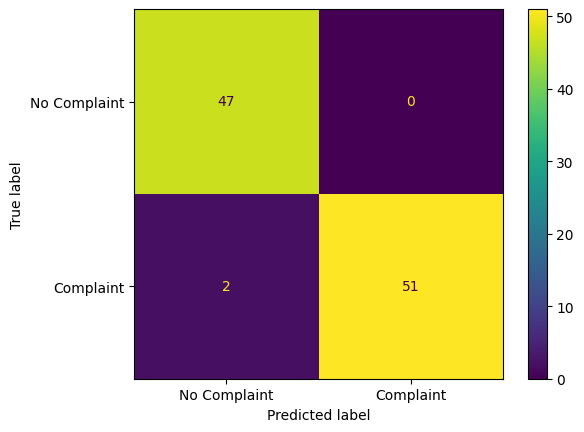

In [54]:
from model_assessment import model_assessment

df_complaints_train_dg["predictions"] = df_complaints_train_dg["predictions"].astype(
    int
)

assessor = model_assessment.ModelAssessor(
    results_getter=None,
    test_data=df_complaints_train_dg,  # .dropna(subset=['predictions']),
    X_column_name="Comment_Text",
    y_column_name="Is_Complaint",
    predictions_column_name="predictions",
)
assessor.get_and_display_confusion_matrix()